In [1]:
from skimage.feature import hog
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## 1. Obtain a set of positive training samples

Let's start by finding some positive training samples that show a variety of faces. We have one easy set of data to work with—the Labeled Faces in the Wild dataset, which can be downloaded by Scikit-Learn:

In [2]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

This gives us a sample of 13,000 face images to use for training.

## 2. Obtain a set of negative training samples
Next we need a set of similarly sized thumbnails which do not have a face in them. One way to do this is to take any corpus of input images, and extract thumbnails from them at a variety of scales. Here we can use some of the images shipped with Scikit-Image, along with Scikit-Learn's PatchExtractor:

In [3]:
from skimage import data, transform,color

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

In [4]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

We now have 30,000 suitable image patches which do not contain faces. Let's take a look at a few of them to get an idea of what they look like:

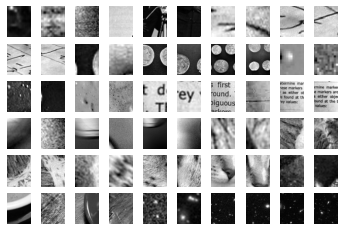

In [5]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

# HOG Features
The Histogram of Gradients is a straightforward feature extraction procedure that was developed in the context of identifying pedestrians within images. HOG involves the following steps:

1. Optionally pre-normalize images. This leads to features that resist dependence on variations in illumination.
2. Convolve the image with two filters that are sensitive to horizontal and vertical brightness gradients. These capture edge, contour, and texture information.
3. Subdivide the image into cells of a predetermined size, and compute a histogram of the gradient orientations within each cell.
4. Normalize the histograms in each cell by comparing to the block of neighboring cells. This further suppresses the effect of illumination across the image.
5. Construct a one-dimensional feature vector from the information in each cell.

A fast HOG extractor is built into the Scikit-Image project, and we can try it out relatively quickly and visualize the oriented gradients within each cell:

## 3. Combine sets and extract HOG features
Now that we have these positive samples and negative samples, we can combine them and compute HOG features. This step takes a little while, because the HOG features involve a nontrivial computation for each image:

In [31]:
from itertools import chain

X_train = np.array([hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [8]:
X_train.shape

(43233, 1215)

We are left with 43,000 training samples in 1,056 dimensions

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
x = scaler.transform(X_train)

In [ ]:
from sklearn.utils import shuffle

x, y = shuffle(x, y_train, random_state=0)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.03, random_state=42)

print(X_train.shape,X_test.shape)

(41936, 1215) (1297, 1215)


## 4. Training a support vector machine
Next we use the tools we have been exploring in this chapter to create a classifier of thumbnail patches. For such a high-dimensional binary classification task, a Linear support vector machine is a good choice. We will use Scikit-Learn's LinearSVC, because in comparison to SVC it often has better scaling for large number of samples.

First, though, let's use a simple Gaussian naive Bayes to get a quick baseline:

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

array([0.97293753, 0.97007273, 0.97054966, 0.97460355, 0.97007273])

We see that on our training data, even a simple naive Bayes algorithm gets us upwards of 90% accuracy. Let's try the support vector machine, with a grid search over a few choices of the C parameter:

In [13]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(LinearSVC(max_iter=2000), {'C': [1.0, 2.0, 4.0, 8.0]},n_jobs=-1,verbose=2)
grid.fit(X_train, y_train)
grid.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.7min finished
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.989078560110087

In [16]:
grid.best_params_

{'C': 1.0}

In [17]:
from sklearn.svm import LinearSVC

svc = LinearSVC(max_iter=2000,C=4.0)

svc.fit(X_train, y_train)
accuracy = svc.score(X_test, y_test)
accuracy

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9884348496530455

We see that on our training data, even a support vector machine gets us upwards of 98% accuracy. Let's try the AdaBoostClassifier with support vector machine, with a grid search over a few choices of the C parameter:

In [18]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(LinearSVC(max_iter=2000), algorithm='SAMME', n_estimators=100, random_state=1)

model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)

In [19]:
accuracy

0.9853508095605242

We see that on our training data, even a AdaBoost Classifier gets us upwards of 98.38% accuracy.

In [20]:
from sklearn.metrics import confusion_matrix

pred1 = svc.predict(X_test) 
confusion_matrix(y_test, pred1)

array([[908,   9],
       [  6, 374]])

In [21]:
pred1 = model.predict(X_test) 
confusion_matrix(y_test, pred1)

array([[908,   9],
       [ 10, 370]])

## 5. Find faces in a new image
Now that we have this model in place, let's grab a new image and see how the model does. We will use one portion of the astronaut image for simplicity (see discussion of this in Caveats and Improvements), and run a sliding window over it and evaluate each patch:

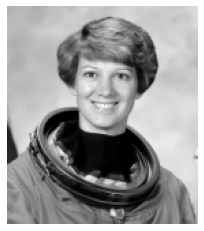

In [22]:
import skimage.data

test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

Next, let's create a window that iterates over patches of this image, and compute HOG features for each patch:

In [26]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([hog(patch) for patch in patches])
patches_hog.shape

(1911, 1215)

Finally, we can take these HOG-featured patches and use our model to evaluate whether each patch contains a face:

In [27]:
patches_hog = scaler.transform(patches_hog)

labels = model.predict(patches_hog)
print(labels.sum())

labels1 =  svc.predict(patches_hog)
print(labels1.sum())

61.0
78.0


We see that out of nearly 2,000 patches, we have found 30 detections. Let's use the information we have about these patches to show where they lie on our test image, drawing them as rectangles:

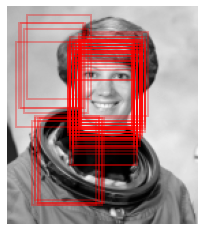

In [28]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

All of the detected patches overlap and found the face in the image! Not bad for a few lines of Python.